In [239]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

Let's investigate how confident parameter measurements may (or may not) relate to the significance of posterior predictive checks. Take the following example:

We'll make noisy measurements $\hat x$ of some quantity $x$.
The quantities $x$ are normally distributed as
\begin{equation}
x \sim N(\mu,1)
\end{equation}
while our measurements are also normally distributed with some known standard deviation:
\begin{equation}
\hat x \sim N(x,\sigma_{\hat x})
\end{equation}

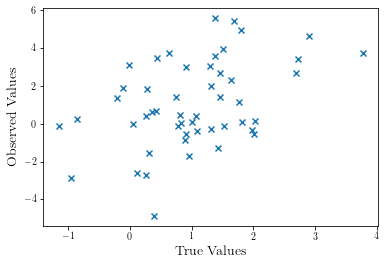

In [240]:
# Define the *true* population mean
mu_true = 1

# Standard deviations of our measurements
sig_x = 2

# Now draw random true values, and then random observed values scattered about truth
xs_true = np.random.normal(loc=mu_true,scale=1,size=50)
xs_obs = np.random.normal(loc=xs_true,scale=sig_x)

fig,ax = plt.subplots()
ax.scatter(xs_true,xs_obs,marker='x')
ax.set_xlabel('True Values',fontsize=14)
ax.set_ylabel('Observed Values',fontsize=14)
plt.show()

Given our set $\{\hat x\}$ of observations, our goal is to hierarchically measure the population mean $\mu$.
The likelihood for $\mu$ is
    \begin{equation}
    \begin{aligned}
    p(\{\hat x\}|\mu) &\propto \prod_{i=1}^{N_\mathrm{obs}} \int dx p(\hat x_i|x) p(x|\mu) \\
        & \propto \prod_{i=1}^{N_\mathrm{obs}}
            \mathrm{Exp}\left(-\frac{(\hat x_i - x)^2}{2\sigma_{\hat x}^2}\right)
            \mathrm{Exp}\left(-\frac{(x - \mu)^2}{2}\right) \\
        & \propto \prod_{i=1}^{N_\mathrm{obs}} \mathrm{Exp}\left(-\frac{(\hat x_i -\mu)^2}{2(1+\sigma_{\hat x}^2)}\right)
    \end{aligned}
    \end{equation}
or
    \begin{equation}
    \log p(\{\hat x\}|\mu) = \sum_{i=1}^{N_\mathrm{obs}} \mathrm{Exp}\left(-\frac{(\hat x_i -\mu)^2}{2(1+\sigma_{\hat x}^2)}\right) + \mathrm{constants}
    \end{equation}

$\mu$ constrained above zero at 99.96% credibility


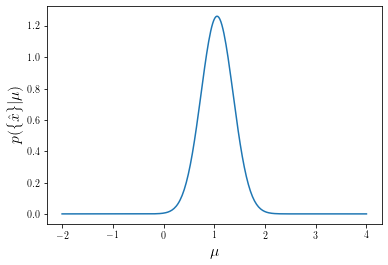

In [241]:
# Set up a grid of proposed mu's over which we can analytically evaluate this likelihood
mu_trials = np.linspace(-2,4,300)
log_p_mu = np.zeros(mu_trials.size)

# For every proposed mu, compute the log-likelihood by summing over observed events
for i,mu in enumerate(mu_trials):
    log_p_mu[i] = np.sum(-(xs_obs-mu)**2/(2.*(1.+sig_x**2)))

# Exponentiate and normalize
p_mu = np.exp(log_p_mu)
dm = mu_trials[1]-mu_trials[0]
p_mu /= np.sum(p_mu)*dm

print(r"$\mu$ constrained above zero at {0:.2f}% credibility".format(100.*np.sum(p_mu[mu_trials>0])*dm))

fig,ax = plt.subplots()
ax.plot(mu_trials,p_mu)
ax.set_xlabel(r"$\mu$",fontsize=16)
ax.set_ylabel(r"$p(\{\hat x\}|\mu)$",fontsize=16)
plt.show()

For completeness, it's fun to demonstrate the "shrinkage" effect achieved by reweighting each individual observation's posterior to our population fit.

First, loop across each event and plot its likelihood. I'm assuming that, by default, we have uniform priors on each $x$, and so I'm being a bit loose with posteriors vs. likelihoods...

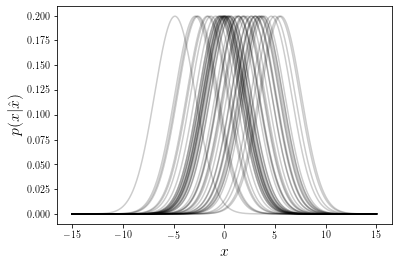

In [242]:
fig,ax = plt.subplots()
for x_obs in xs_obs:
    
    xs = np.linspace(-15,15,3000)
    ys = np.exp(-(xs-x_obs)**2/(2.*sig_x**2))
    ys /= np.trapz(ys,xs)
    ax.plot(xs,ys,color='black',alpha=0.2)

ax.set_xlabel(r"$x$",fontsize=16)
ax.set_ylabel(r"$p(x|\hat x)$",fontsize=16)
plt.show()

For comparison, we can alternatively update our beliefs about each measurement using the above likelihood for $\mu$. Marginalized over possible $\mu$, our updated posterior on any particular $x_i$ is
    \begin{equation}
    p(x_i | \hat x_i) \propto \int d\mu \,\,p(\hat x_i| x_i) p(x_i|\mu) p(\mu|\{\hat x\})
    \end{equation}
(Note that I'm just ignoring the slight subtlety about whether or not $\hat x_i$ should itself be included in the set of observations informing $p(\mu|\{\hat x\}$)

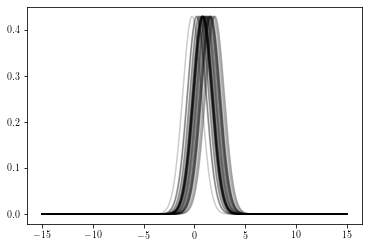

In [243]:
# To assist in integration, prepare a grid over (true) x and \mu values
int_grid = np.zeros((xs.size,mu_trials.size))

# Compute p(x|mu)*p(mu) for every mu
for i in range(mu_trials.size):
    int_grid[:,i] = np.exp(-(xs-mu_trials[i])**2/2.)*p_mu[i]
    
# Now achieve the integration by summing our grid in the "mu" direction and normalizing
pop_prior = np.trapz(int_grid,mu_trials,axis=1)
pop_prior /= np.trapz(pop_prior,xs)

# For every event, plot the updated posterior
fig,ax = plt.subplots()
for x_obs in xs_obs:

    ys = np.exp(-(xs-x_obs)**2/(2.*sig_x**2))*pop_prior
    ys /= np.trapz(ys,xs)
    ax.plot(xs,ys,color='black',alpha=0.2)
    
plt.show()

So far, we've shown that our toy observations allow us to constrain $\mu$ above zero at very high credibility. Now let's turn to some predictive checks and explore what kind of significances we see there.

Let's assume that the hypothesis we are trying to **disprove** is one in which $\mu = 0$. We'll  approach this by comparing "predicted" catalogs drawn from the population $N(\mu = 0,1)$ with "observed" catalogs built using our measurements $\{\hat x\}$ (based on the **true** population with $\mu \ne 0$), reweighted to the population prior we wish to falsify.

The following cell shows an example of generating one such predicted and one observed catalog: 

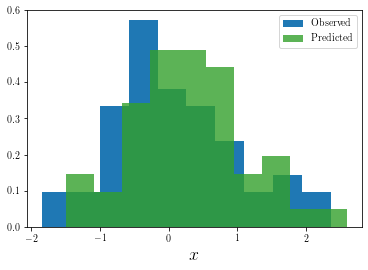

In [244]:
# Draw a predicted set of events from a distribution centered at zero
predicted_catalog = np.random.normal(loc=0,scale=1,size=50)

# Now let's construct our "observed set"
observed_catalog = np.zeros(xs_obs.size)
for i in range(xs_obs.size):
    
    # We need to reweight each event's posterior to the population prior in question
    # Do this by multiplying p(x|\hat x) by a Gaussian centered at zero and renormalize
    ys = np.exp(-(xs-x_obs)**2/(2.*sig_x**2))*np.exp(-(xs-0.)**2/2.)
    ys /= np.trapz(ys,xs)
    
    # Now draw a single "observed" value from this posterior via computing the inverse CDF 
    cdfs = np.cumsum(ys)*(xs[1]-xs[0])
    observed_catalog[i] = np.interp(np.random.random(),cdfs,xs)
    
fig,ax = plt.subplots()
obs_color = "#1f78b4"
pred_color = "#33a02c"
ax.hist(observed_catalog,bins=10,color=obs_color,density=True,label='Observed')
ax.hist(predicted_catalog,alpha=0.8,bins=10,color=pred_color,density=True,label='Predicted')
plt.legend()
ax.set_xlabel(r"$x$",fontsize=18)
plt.show()

The above catalog, though, is only one of many possible realizations.

Therefore, let's loop across many catalog realizations. For each pair of catalog realizations, compute and store the **max** value of $x$. Since we, with our God's-eye view, know that $\mu = 1$, our hypothesis is that the "predicted" catalogs should systematically yield smaller values of $\mathrm{max}(x)$ than the "observed" catalogs.

In [245]:
# Initialize arrays to hold results for many different catalog instantiations
n_trials = 100
max_observed = np.zeros(n_trials)
max_predicted = np.zeros(n_trials)

# Loop over catalog draws
for i in range(n_trials):
    
    # As above, generated a predicted catalog from our null distribution
    predicted_catalog = np.random.normal(loc=0,scale=1,size=50)
    
    # Also as above, compute an "observed" catalog by reweighting every individual measurement
    # and drawing a single representative sample
    observed_catalog = np.zeros(xs_obs.size)
    for ii in range(xs_obs.size):
    
        # (Technically this doesn't need to be done inside the loop, but whatever...)
        ys = np.exp(-(xs-xs_obs[ii])**2/(2.*sig_x**2))*np.exp(-(xs-0.)**2/2.)
        ys /= np.trapz(ys,xs)

        cdfs = np.cumsum(ys)*(xs[1]-xs[0])
        observed_catalog[ii] = np.interp(np.random.random(),cdfs,xs)
        
    # With our pair of catalogs in hand, compute and store the maximum of each
    max_observed[i] = np.max(observed_catalog)
    max_predicted[i] = np.max(predicted_catalog)

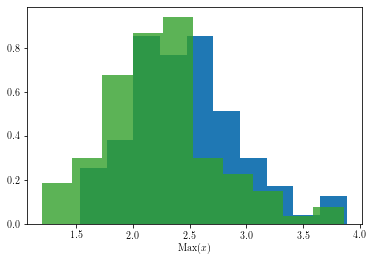

The null hypothesis underpredicts the max $x$ 63.00% of the time


In [246]:
fig,ax = plt.subplots()
ax.hist(max_observed,bins=10,color=obs_color,density=True,label='Observed')
ax.hist(max_predicted,alpha=0.8,bins=10,color=pred_color,density=True,label='Predicted')
ax.set_xlabel(r"Max($x$)")
plt.show()

underprediction_fraction =  np.where(max_predicted<max_observed)[0].size/max_predicted.size
print(r"The null hypothesis underpredicts the max $x$ {0:.2f}% of the time".format(100.*underprediction_fraction))

Rerun this notebook to see how things vary (sometimes quite a bit) from run to run, and/or with different measurement uncertainties!